# Geology and Uranium

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install xarray
    !pip install matplotlib-scalebar
    !pip install contextily


In [ ]:
import os
import pandas as pd
import numpy as np
import contextily as cx
import fiona
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import warnings

# Auto reloads notebook when changes are made
%reload_ext autoreload
%matplotlib inline
%autoreload 2
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir =  '/content/drive/MyDrive/Thesis/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import custom scripts
import sys
sys.path.append(os.path.join(base_dir, 'scripts'))
import importlib

import Config
importlib.reload(Config)

from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict, RenameUnit)

import Utils
importlib.reload(Utils)
from Utils import (plot_boxplot_by_category, plot_histograms_by_category,
                   calculate_aggregated_stats,
                   )
from Utils import GeodataProcessor as GP

In [ ]:
#Import data
shapefiles_dir='/content/drive/MyDrive/Thesis/data/processed_data/shapefiles/'
gpkg_path = '/content/drive/MyDrive/Thesis/Database.gpkg'

radon_df = gpd.read_file(gpkg_path, layer='processed_data')


radon_dir = os.path.join(shapefiles_dir, 'processed_radon_data/Final_processed_data.shp')
geology = os.path.join(shapefiles_dir, 'Geology')

project_crs = "EPSG:25832"
radon_and_covariates = gpd.read_file(radon_dir)[['Rn_Poten', 'PERMEABILI',
                                     'RADON_RN_3', 'GRP_conc',
                                      'geometry']]
geologyUTM = gpd.read_file(os.path.join(geology, "geol_map_UTM32N.shp"))
geology300k = gpd.read_file(os.path.join(geology, "GUEK300_Geol_Hessen.shp"))
Hessen = gpd.read_file(os.path.join(shapefiles_dir, 'Hessen boundaries/AOI_Hessen.shp'))
geologyUTM.crs == geology300k.crs == radon_df.crs
print(f"main data: {fiona.listlayers(gpkg_path)}")

# '‘3-degree Gauss-Kruger zone 3, EPSG:31467’'

main data: ['BHR1', 'BHW2', 'Wolfskehlen', 'Leinhardt', 'processed_data', 'processed_data_folds', 'Training_data', 'Validation_data', 'AOI_Hessen', 'AOI_wolf', 'Tectonics', 'Landkreis']


In [ ]:
# helper functions

def calculate_risk_intervals(df):
  """
  Calculate the risk level of the samples based on calculated GRP
  """
  conditions = [(df['GRP']< 22), (df['GRP']< 44), (df['GRP']> 44)]
  mapping = ['<22','22 - 44','>44']
  df['Risk class'] = np.select(conditions,mapping, default=0)

  return df
#radon_df = calculate_risk_intervals(radon_df)

def missing_values_info(df):
    """
    Missing values and the percentage for each column in the DataFrame.
    """
    samples = df.count().to_frame(name='samples')
    missing_values = df.isnull().sum().to_frame(name='missing values')
    missing_percentage = (df.isnull().mean() * 100).round(2).to_frame(name='% missing values')
    missing_info = samples.join(missing_values).join(missing_percentage)

    return missing_info

def unique_values_and_null_count(df):
    """
    Unique values and null values frequency for each column in the DataFrame.
    """
    unique_values = df.nunique().to_frame(name='unique values')
    null_values = df.isnull().sum().to_frame(name='null count')
    unique_vals_with_null = unique_values.join(null_values)
    return unique_vals_with_null

def print_seperator(text):
    print("\n")
    print('='*200)
    print(text)
    print('='*200)
    print("\n")


### G300k

In [ ]:
print_seperator('Missing values')

print(missing_values_info(geology300k))

print_seperator('Unique values')

print(unique_values_and_null_count(geology300k))




Missing values


            samples  missing values  % missing values
LAND_ID         130               0              0.00
LAND_TXT        130               0              0.00
GEO_ID          130               0              0.00
GEO_KUERZE      130               0              0.00
FORMATION       130               0              0.00
PETROGRAPH      130               0              0.00
SUBGRUPPE        36              94             72.31
GRUPPE           62              68             52.31
SUBSERIE         11             119             91.54
SERIE           103              27             20.77
SUBSYSTEM        16             114             87.69
SYSTEM          130               0              0.00
Shape_Leng      130               0              0.00
Shape_Area      130               0              0.00
geometry        130               0              0.00


Unique values


            unique values  null count
LAND_ID                 2           0
LAND_TXT               

In [ ]:
def plot_map(df, column, figsize):
    """
    Plots the sampling point on an OpenStreetMap.
    """
    df.plot(column=column, cmap='jet', figsize=(13, 10),
            legend=True, edgecolor='black', linewidth=0.2,
            legend_kwds={'loc': 'lower right', 'framealpha': 0.7,
                         'fontsize': 7, 'title_fontsize': 8})

    plt.axis('off')

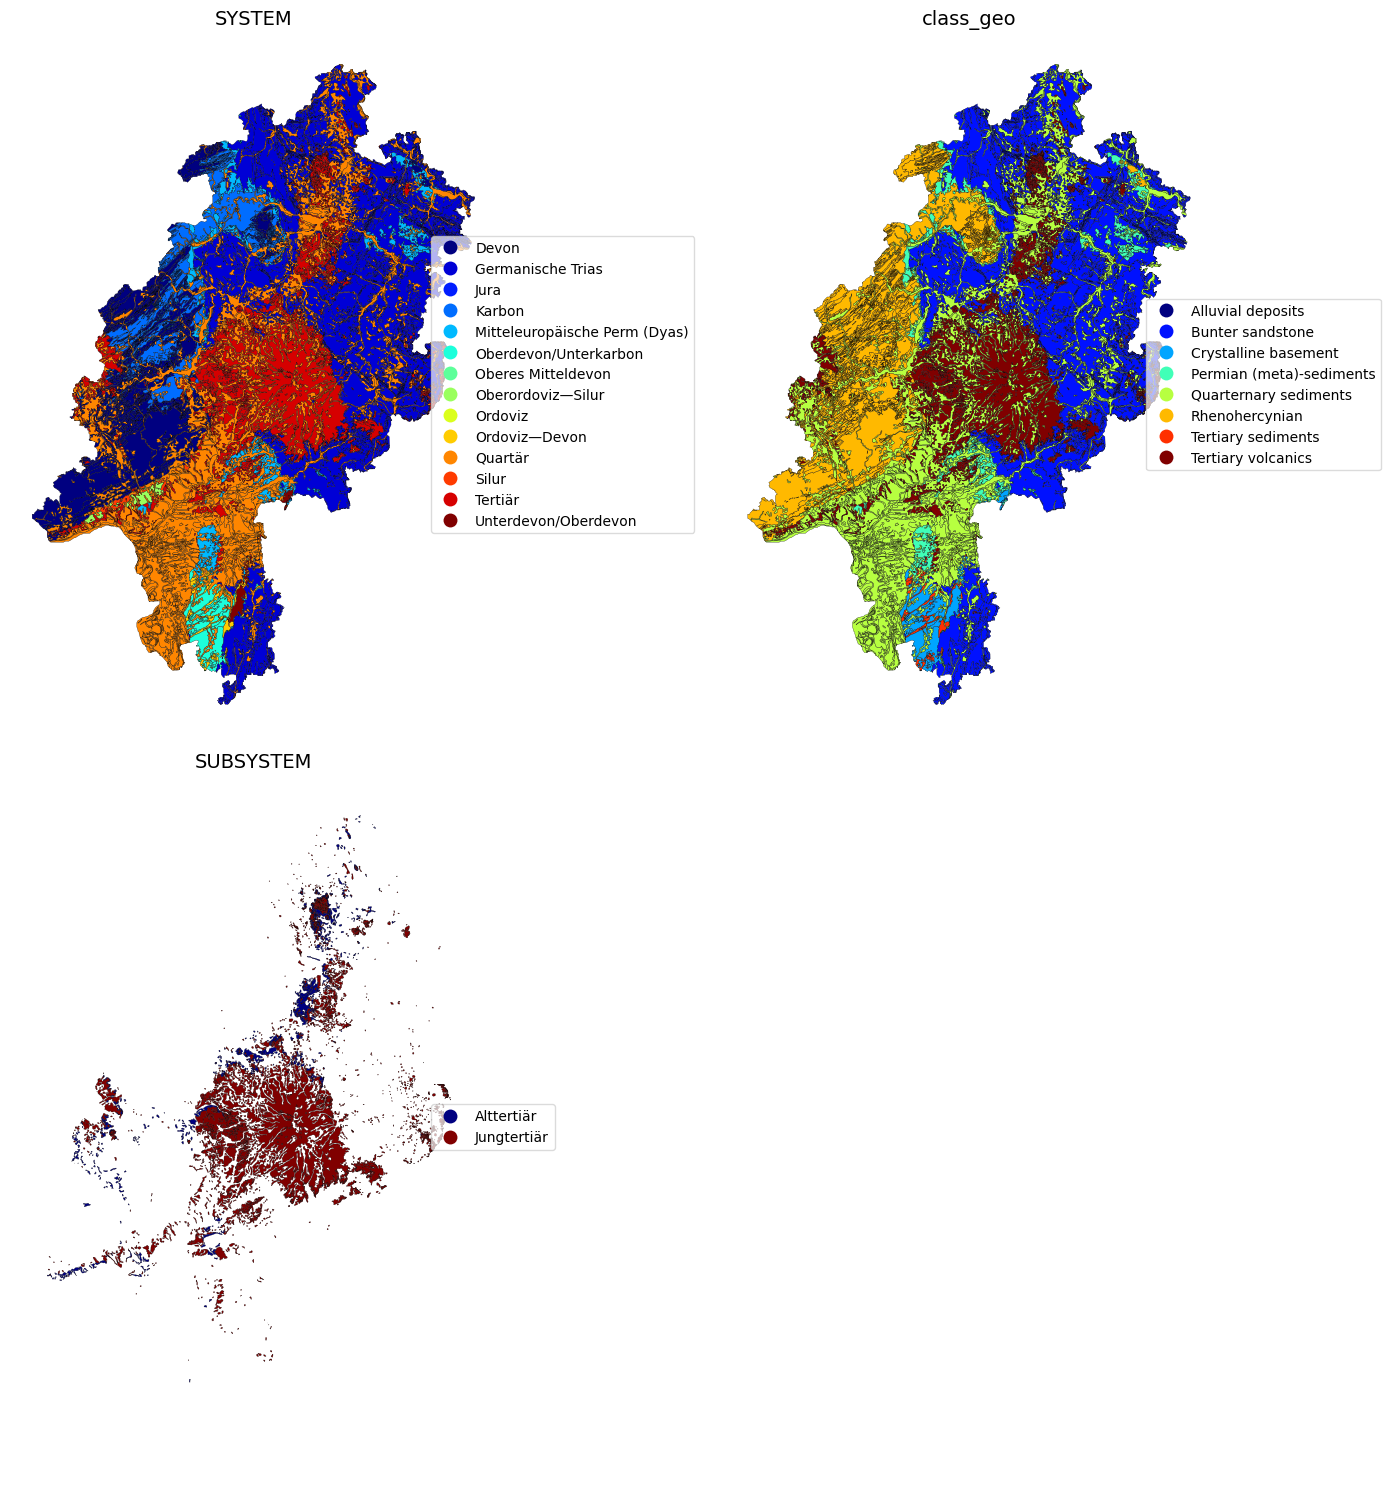

In [ ]:
System_col = ['Quartär', 'Mitteleuropäische Perm (Dyas)', 'Devon', 'Silur',
       'Oberordoviz—Silur', 'Ordoviz—Devon', 'Oberdevon/Unterkarbon',
       'Oberes Mitteldevon', 'Unterdevon/Oberdevon', 'Ordoviz', 'Karbon',
       'Tertiär', 'Jura', 'Germanische Trias']

new_geol_col = ['Quarternary sediments', 'Permian (meta)-sediments', 'Rhenohercynian',
              'Quarternary sediments','Quarternary sediments', 'Tertiary sediments',
              'Crystalline basement','Alluvial deposits', 'Crystalline basement',
              'Alluvial deposits', 'Rhenohercynian','Tertiary volcanics', 'Alluvial deposits',
              'Bunter sandstone']

def replace_vals(gdf, new_column, ref_column, old_units, new_units):
  """
  Replace old values with new values in a specific column (e.g., 'column_name')
  """
  value_mapping = dict(zip(old_units, new_units))
  gdf[new_column] = gdf[ref_column].replace(value_mapping)

  return gdf

Geo300k = replace_vals(geology300k, 'class_geo', 'SYSTEM', System_col, new_geol_col)

# selecting diferent columns to inspect suitability
geo300k_cols = ['SYSTEM',
                'class_geo', 'SUBSYSTEM']
# Plot both geologies
fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
axes = axes.flatten()
for i, column in enumerate(geo300k_cols):
    ax = axes[i]
    Geo300k.plot(column=column, cmap='jet', ax=ax, legend=True, edgecolor='black', linewidth=0.2,
            legend_kwds={'loc': 'center left','bbox_to_anchor': (0.85, 0.5),'framealpha': 0.7,
                    'fontsize': 10,'title_fontsize': 12 })
    ax.set_title(f"{column}", fontsize=14)
    ax.axis('off')
    for j in range(len(geo300k_cols), 4):
        axes[j].axis('off')
plt.tight_layout()
plt.show()

### geologyUTM

In [ ]:
print_seperator('Missing values')
print(missing_values_info(geologyUTM))
print_seperator ('Unique values')
print(unique_values_and_null_count(geologyUTM))



Missing values


            samples  missing values  % missing values
FID_1          1409               0              0.00
AREA           1409               0              0.00
PERIMETER      1409               0              0.00
GEO            1409               0              0.00
SYMBOL         1390              19              1.35
STRATIGRAP     1384              25              1.77
STRAT_SYM      1384              25              1.77
GENESE         1172             237             16.82
GEN_SYM        1112             297             21.08
PETROGRAPH     1338              71              5.04
PET_SYM        1168             241             17.10
BEMERKUNGE      591             818             58.06
SHAPE_Leng     1409               0              0.00
Strat          1409               0              0.00
Strat2         1409               0              0.00
hlnug          1409               0              0.00
Geo_class      1409               0              0.00
Shape_Le_

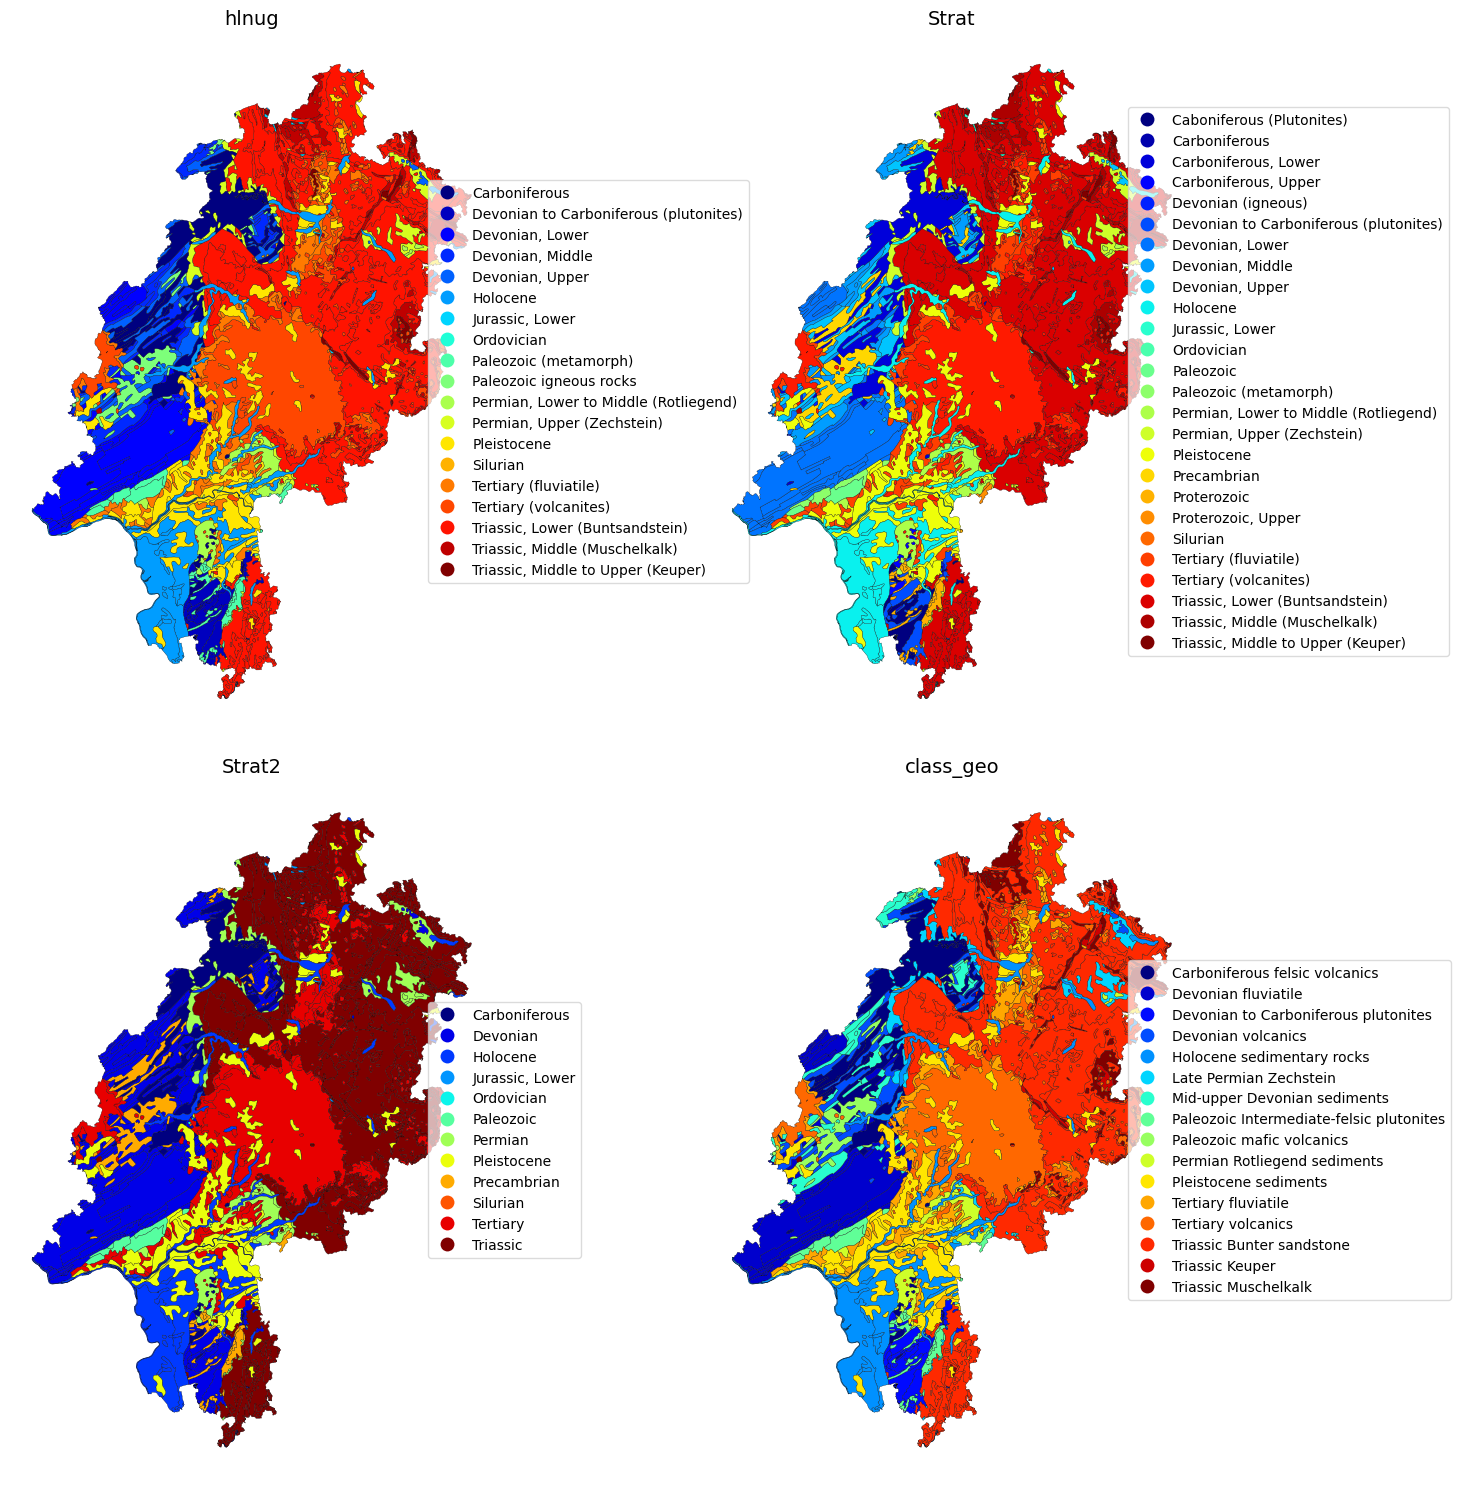

In [ ]:
# rename geology units
processor = RenameUnit(geologyUTM, 'hlnug')
geologyUTM_updated = processor.process_geology_columns()

# plotting diferent columns to inspect suitability
geol_columns=['hlnug', 'Strat', 'Strat2', 'class_geo']

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
axes = axes.flatten()
for i, column in enumerate(geol_columns):
    ax = axes[i]
    geologyUTM_updated.plot(column=column, cmap='jet', ax=ax, legend=True,
                            edgecolor='black', linewidth=0.2,
            legend_kwds={'loc': 'center left','bbox_to_anchor': (0.85, 0.5),
                         'framealpha': 0.7,
                    'fontsize': 10,'title_fontsize': 12 })
    ax.set_title(f"{column}", fontsize=14)
    ax.axis('off')
    for j in range(len(geol_columns), 4):
        axes[j].axis('off')
plt.tight_layout()
plt.show()

<Axes: >

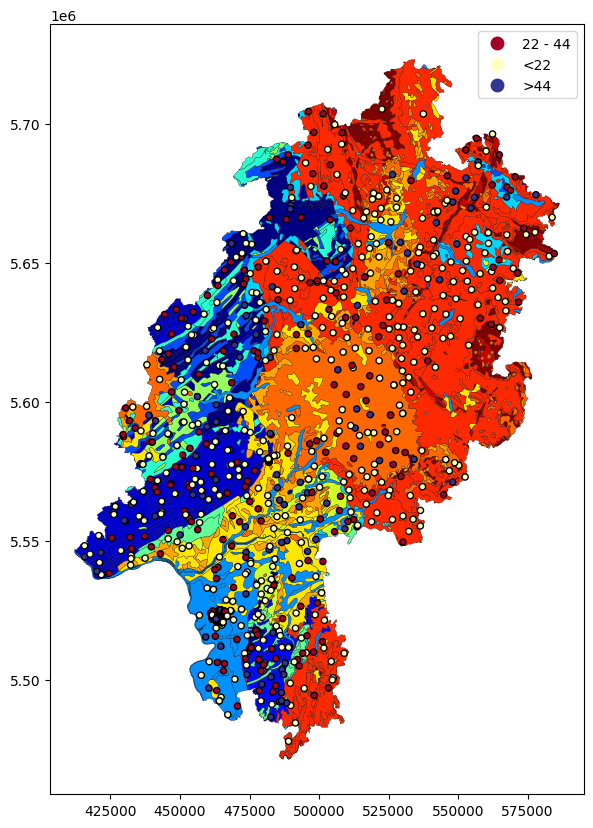

In [ ]:
fig, ax = plt.subplots(figsize=(13,10))

geologyUTM_updated.plot(ax=ax, column='class_geo', cmap='jet',
        legend=True, edgecolor='black', linewidth=0.2,
        legend_kwds={'loc': 'lower right', 'framealpha': 0.7,
                      'fontsize': 5, 'title_fontsize': 6})

radon_df.plot(ax=ax, column='Risk class', cmap='RdYlBu',
              edgecolor='black', markersize=20, legend=True)

#plt.axis('off')


### Distribution of radon in geological units


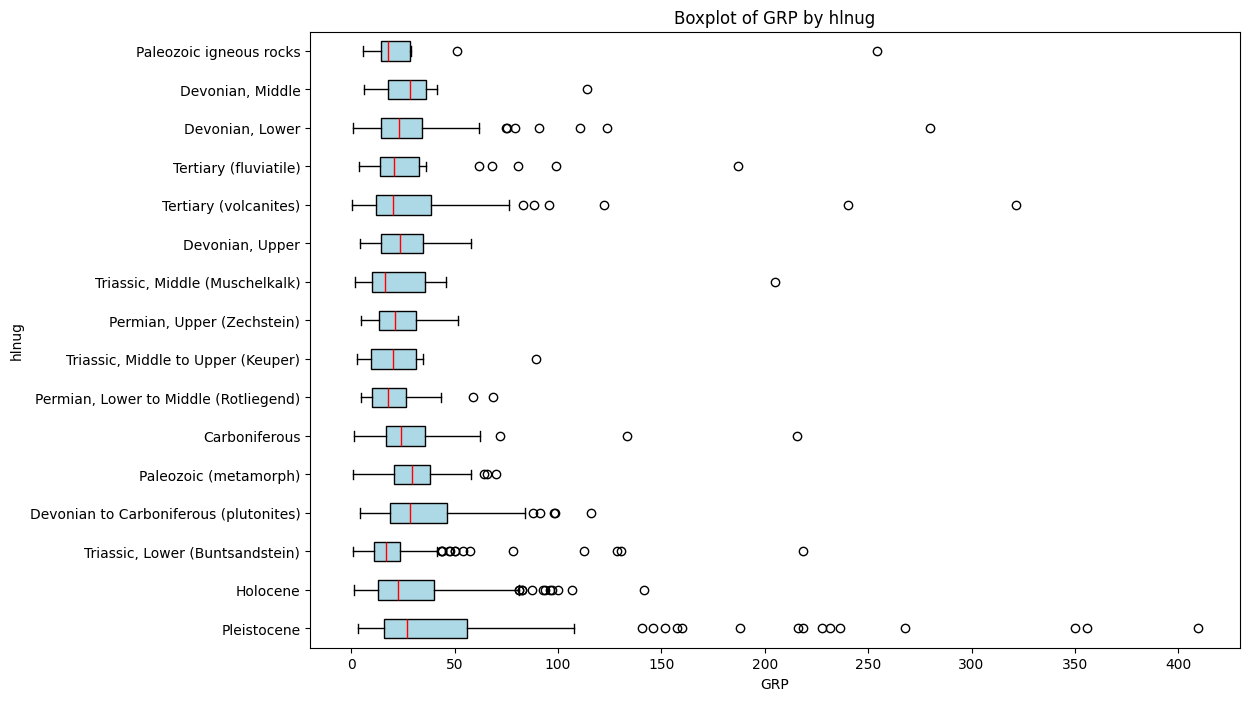

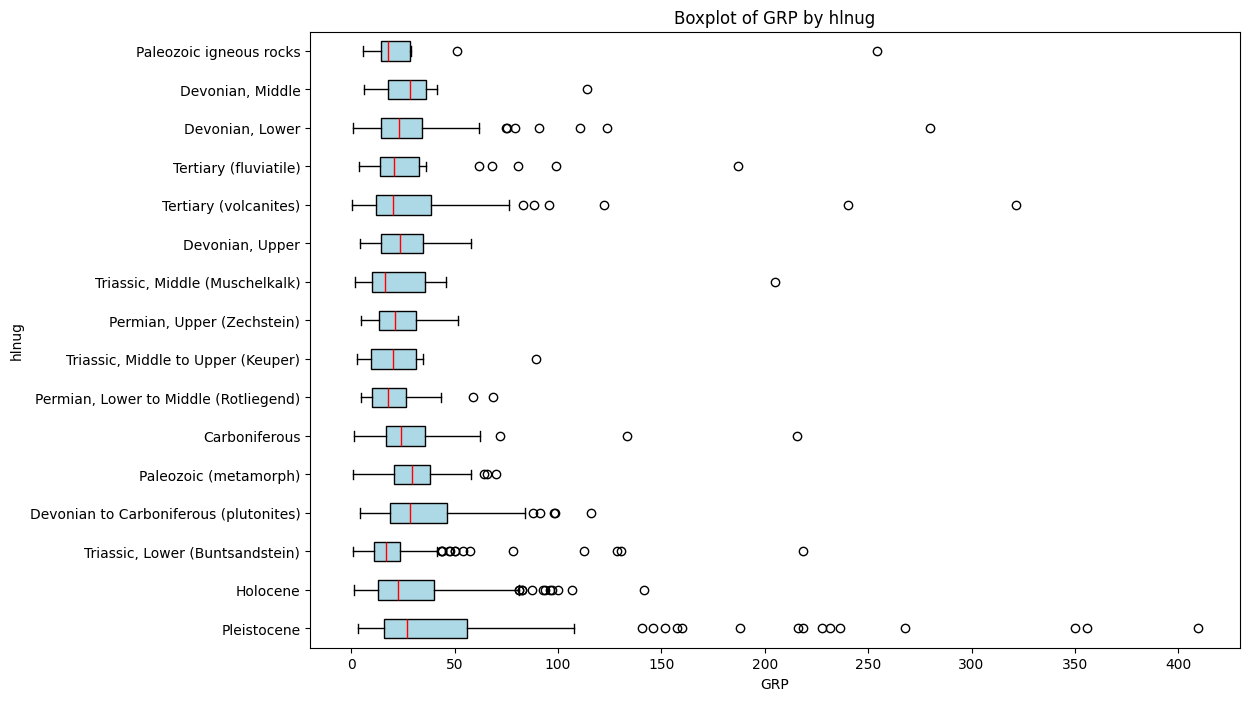

In [ ]:
#Join radon and geology
geology_radon = GP.spatial_join_pol_pts(
    radon_df, geologyUTM_updated[['Strat','Strat2',
                                  'class_geo','geometry']])
geology_radon_box = geology_radon.copy()

#plot categorical columns
plot_boxplot_by_category(geology_radon, 'hlnug', 'GRP', log_transform=False)
plot_boxplot_by_category(geology_radon, 'hlnug', 'GRP', log_transform=False)



Median GRP per geology unit




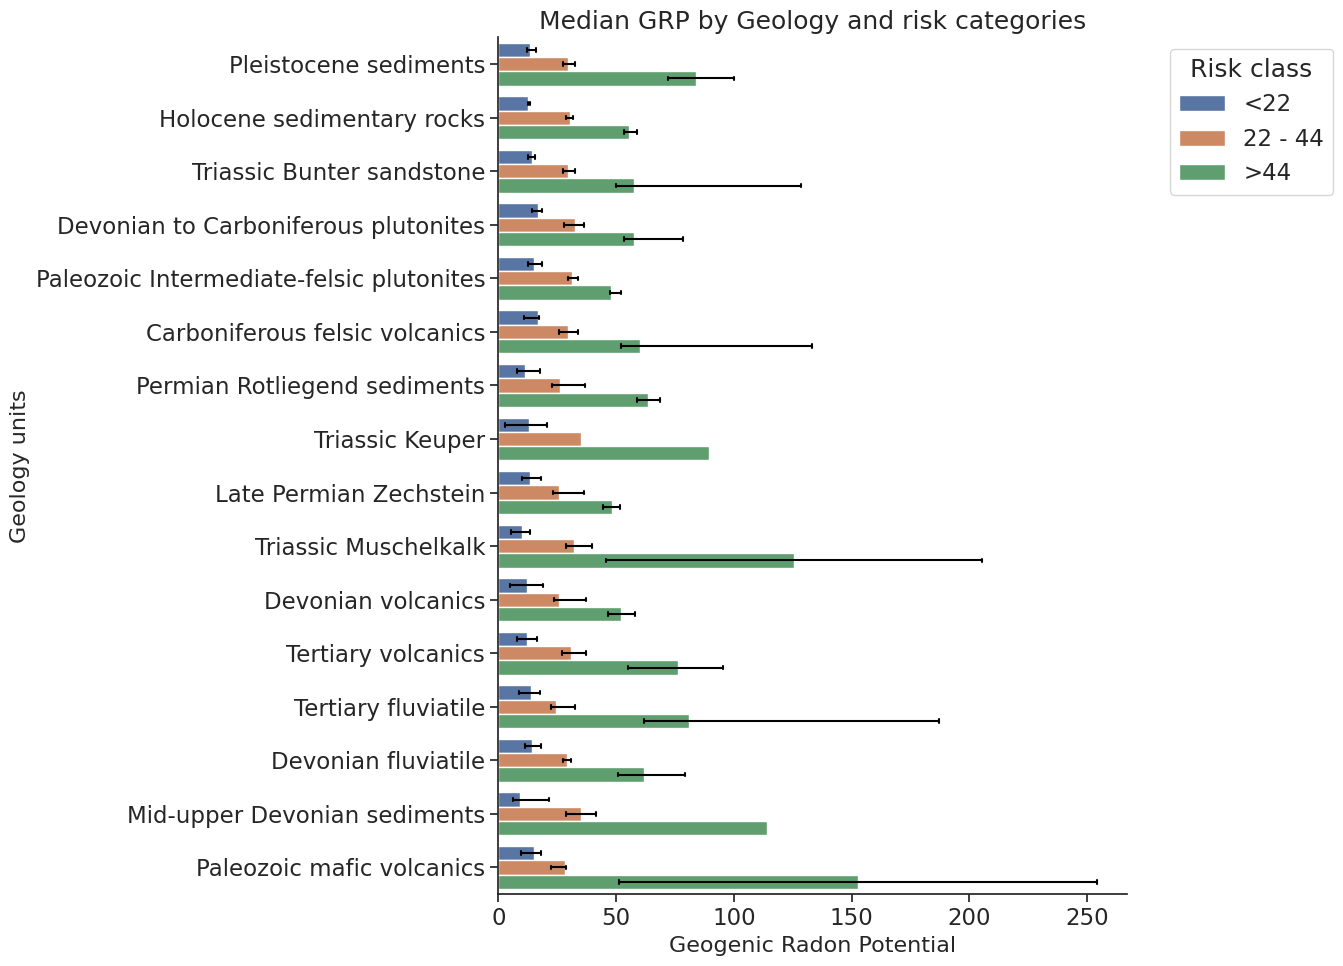



percentage of GRP per geology unit




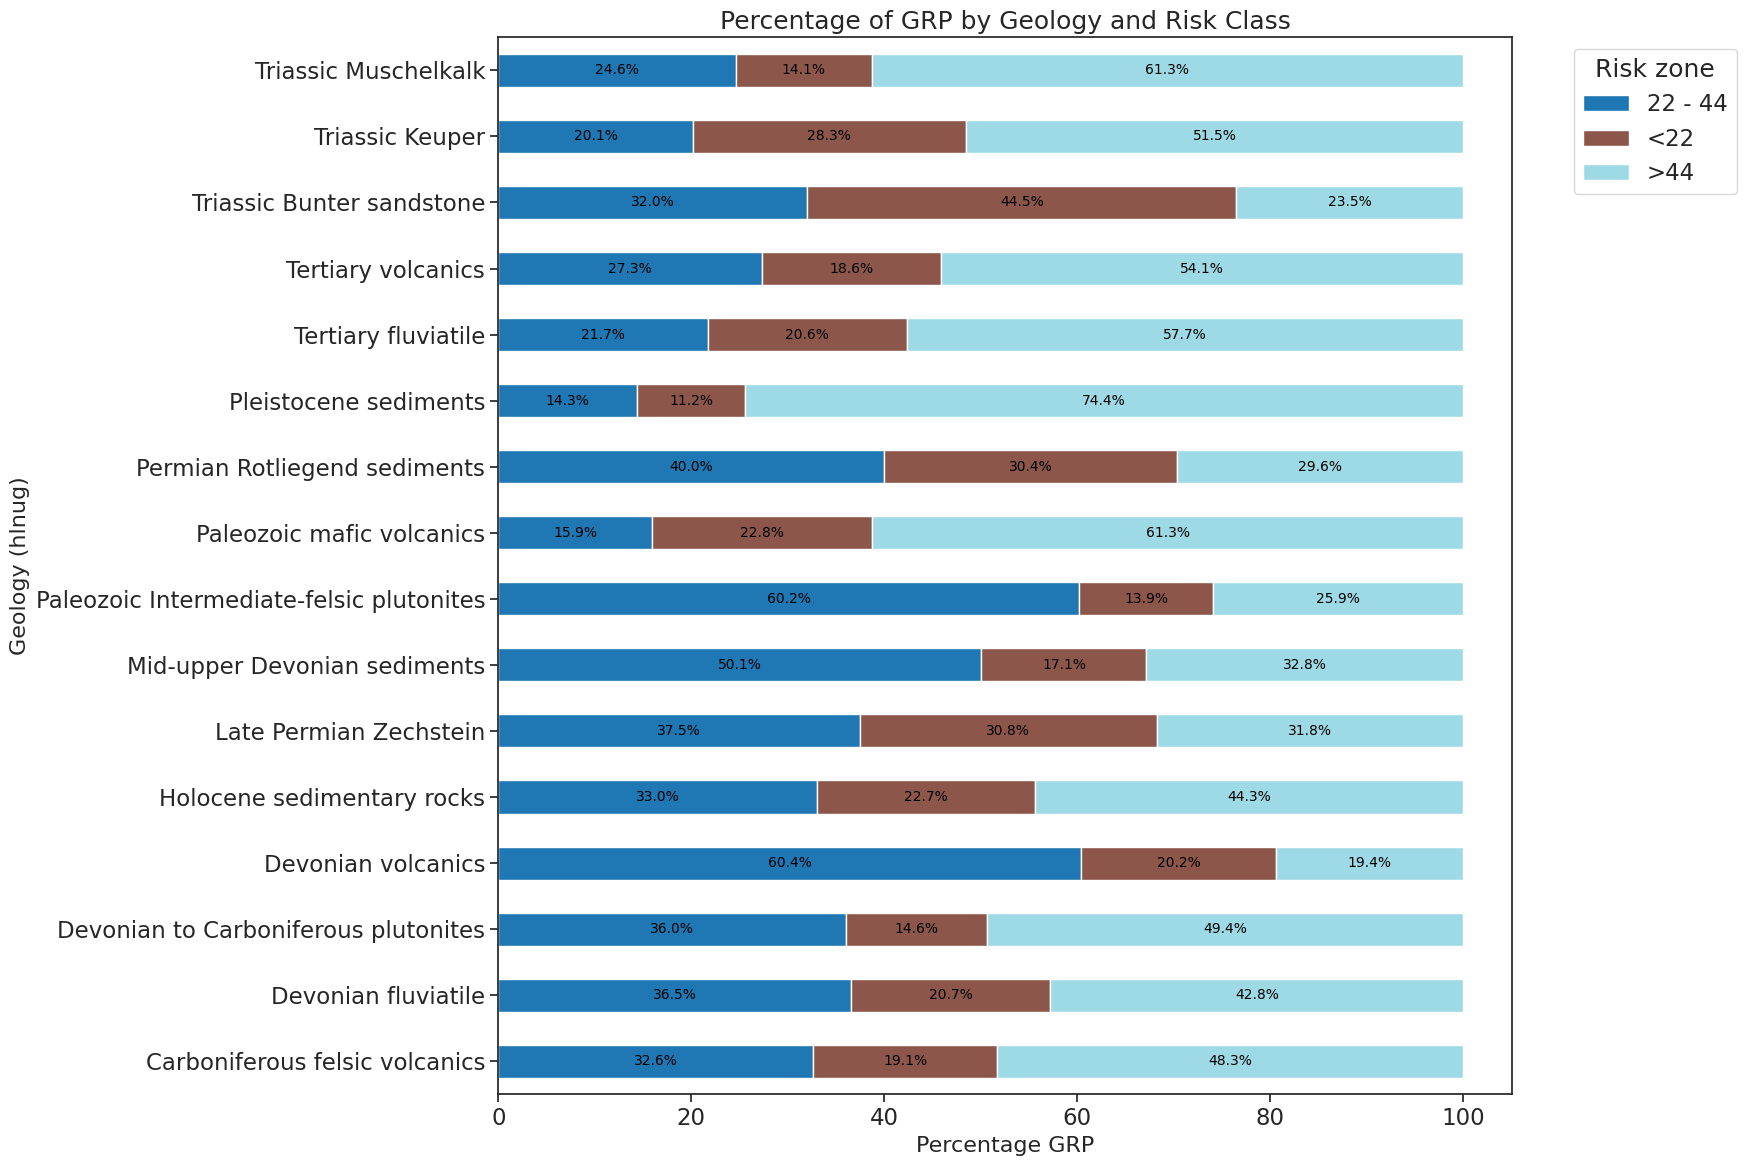



Histogram of GRP per geology unit




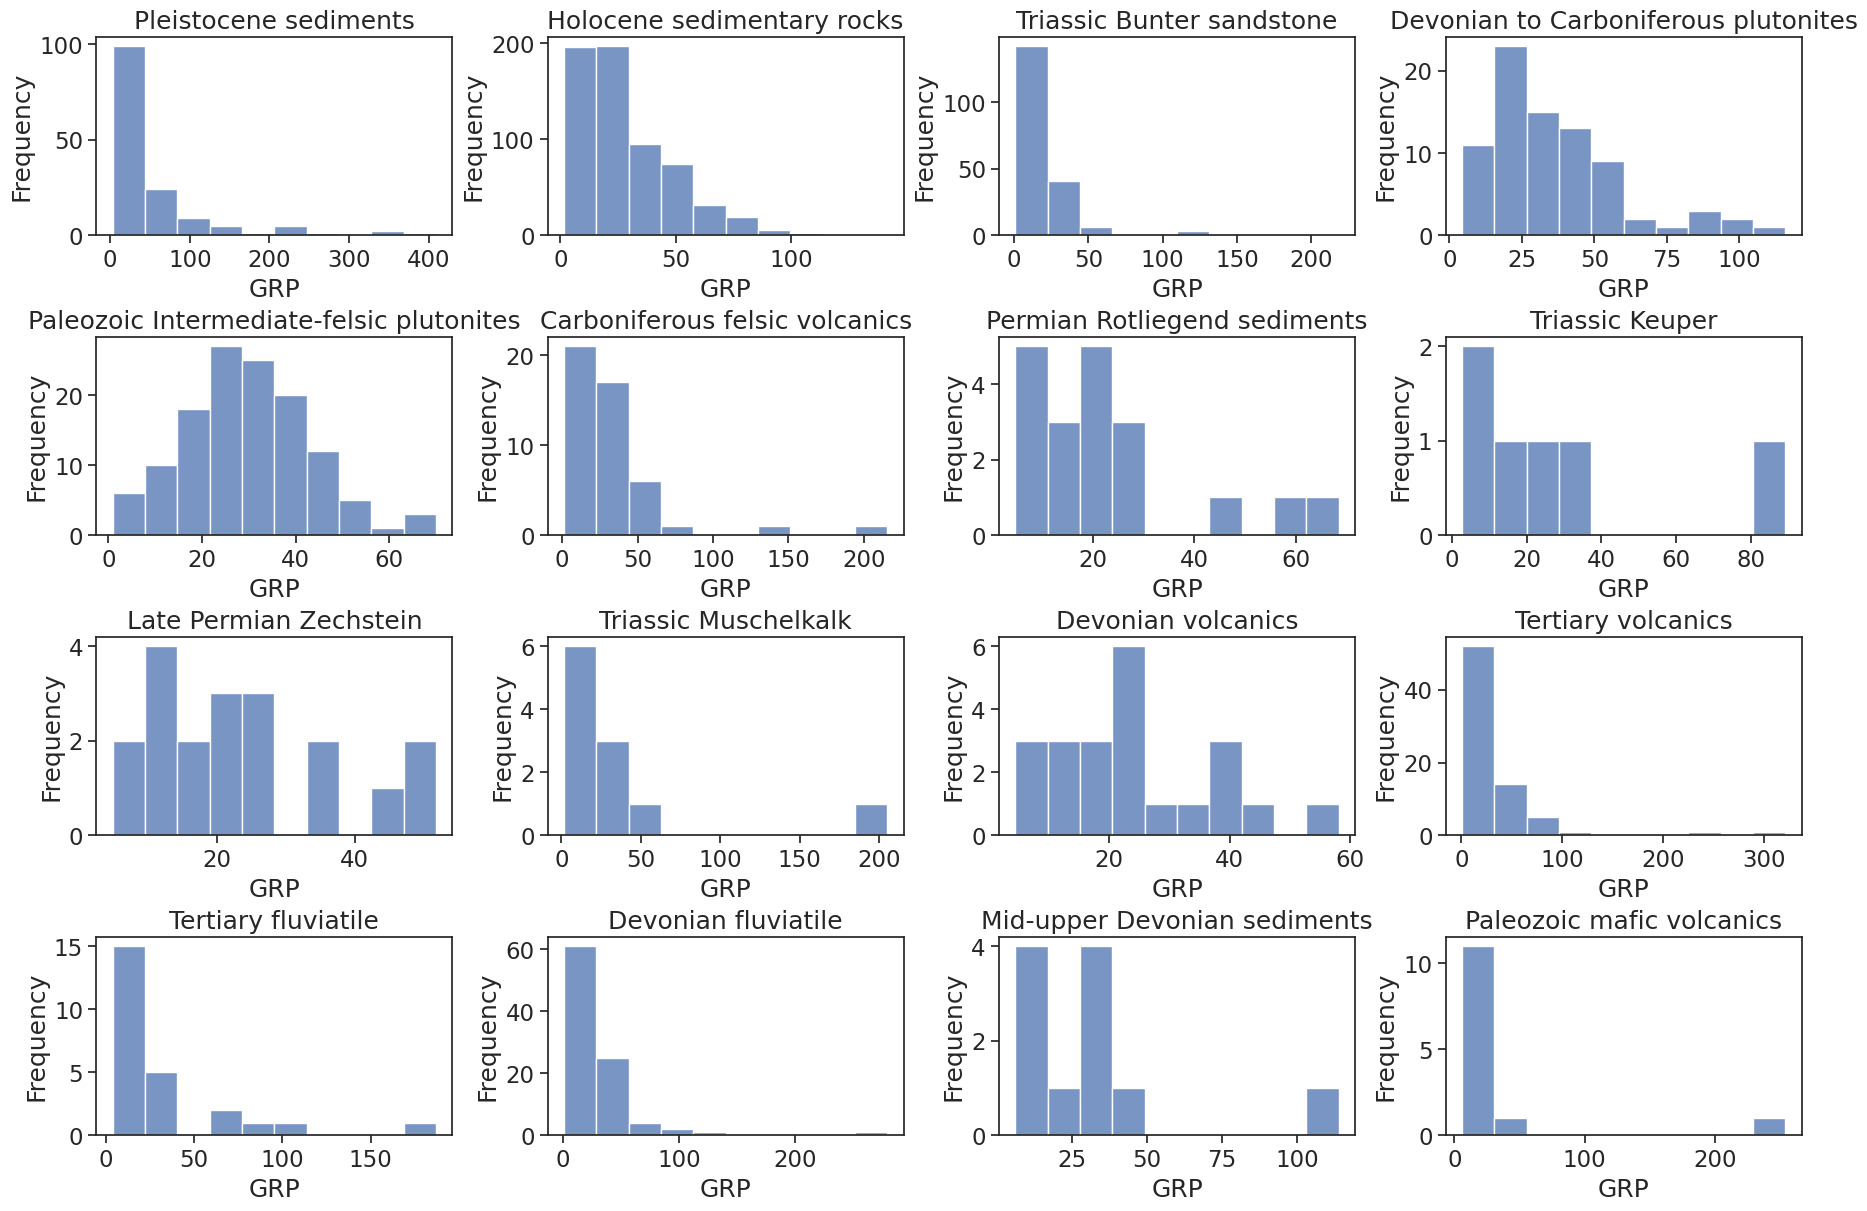

In [ ]:
#plots per geology units

print_seperator('Median GRP per geology unit')

# Median GRP per geology unit
sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(14, 10))
sns.barplot(y='class_geo', x='GRP', data=geology_radon, estimator=np.median,
            hue='Risk class',errcolor='black', errwidth=1.5, capsize=0.2)
plt.xlabel('Geogenic Radon Potential', fontsize=16)
plt.ylabel('Geology units', fontsize=16)
plt.title('Median GRP by Geology and risk categories', fontsize=18)
plt.legend(title='Risk class', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

print_seperator('percentage of GRP per geology unit')

# Percentage GRP per geology unit
agg_df = geology_radon.groupby(
    ['class_geo', 'Risk class']
    )['GRP'].sum().unstack(fill_value=0)
agg_df_percent = agg_df.div(agg_df.sum(axis=1), axis=0) * 100
ax = agg_df_percent.plot(kind='barh', stacked=True, figsize=(18,12),
                         cmap='tab20')
for bars in ax.containers:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            label_x_pos = bar.get_x() + width / 2
            ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2,
                    f'{width:.1f}%', ha='center', va='center', color='black',
                    fontsize=10)
plt.xlabel('Percentage GRP', fontsize=16)
plt.ylabel('Geology (hlnug)', fontsize=16)
plt.title('Percentage of GRP by Geology and Risk Class', fontsize=18)
plt.legend(title='Risk zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print_seperator('Histogram of GRP per geology unit')

# Histogram of GRP per geology unit
nrows = 4
categories = geology_radon['class_geo'].unique()
num_categories = len(categories)
cols = int(np.ceil(num_categories / nrows))
fig, axes = plt.subplots(nrows, cols, figsize=(18,12), constrained_layout=True)
axes = axes.flatten()
for i, category in enumerate(categories):
    ax = axes[i]
    sns.histplot(geology_radon[geology_radon.class_geo == category]['GRP'],
                 bins=10, kde=False, ax=ax)
    ax.set_title(f'{category}')
    ax.set_xlabel('GRP')
    ax.set_ylabel('Frequency')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

### Ranking geology based on Rn readings

In [ ]:
#median_value_by_strata

print(calculate_aggregated_stats(geology_radon, group_col='class_geo',
                           value_col='GRP', agg_type='median').reset_index())

# Using the 90th percentile for ranking
#percentile_value_by_strata = calculate_aggregated_stats(
#    geology_radon, group_col='hlnug', value_col='GRP', agg_type='percentile',
#                                                        percentile=90)
#percentile_value_by_strata

                                   class_geo   min     max   mean  Median  count    std  Rank
0   Paleozoic Intermediate-felsic plutonites  0.91   70.04  29.84   29.56    127  13.26   1.0
1       Devonian to Carboniferous plutonites  4.33  115.95  36.09   28.63     80  23.40   2.0
2               Mid-upper Devonian sediments  6.01  113.85  31.52   28.50     11  30.01   3.0
3                      Pleistocene sediments  3.02  409.43  52.63   26.95    147  69.61   4.0
4                        Devonian fluviatile  0.76  280.00  30.77   24.05     94  33.72   5.0
5             Carboniferous felsic volcanics  1.22  215.62  33.39   23.91     47  35.16   6.0
6                         Devonian volcanics  4.39   58.10  24.50   23.55     22  13.92   7.0
7                 Holocene sedimentary rocks  1.47  141.77  28.43   22.50    620  20.07   8.0
8                     Late Permian Zechstein  4.88   51.83  23.93   21.30     19  13.63   9.0
9                        Tertiary fluviatile  3.89  187.05  

# Uranium

In [ ]:
# Import data
Uranium_ = gpd.read_file(os.path.join(base_dir, 'geology/Uranium_processed.shp'))
Uranium = Uranium_[Uranium_['U_PPM'] <= 30]
print(f'Sample size of Uranium :{Uranium.shape[0]}')
print()
Uranium_cl = geologyUTM_updated[['AREA', 'PETROGRAPH', 'hlnug',
       'Shape_Area', 'geometry',]]
print(Uranium.describe())

Sample size of Uranium :1183

             U_PPM   Kriging_Ur     OBJECTID   RASTERVALU          GEO       GEO_ID
count  1183.000000  1183.000000  1183.000000  1183.000000  1183.000000  1183.000000
mean      2.772257     2.584568   489.538462     2.322456   638.554522    40.267963
std       2.945975     1.940745   373.676652     3.009009   286.388694    38.982708
min       0.017647     0.000000     0.000000     0.000000     0.000000     0.000000
25%       1.000000     1.270785   131.500000     0.812261   670.000000    12.000000
50%       1.890000     2.262950   467.000000     1.752440   791.000000    12.000000
75%       3.422569     2.909005   813.500000     2.865335   791.000000    85.000000
max      29.000000    10.909000  1183.000000    47.430300   839.000000   106.000000


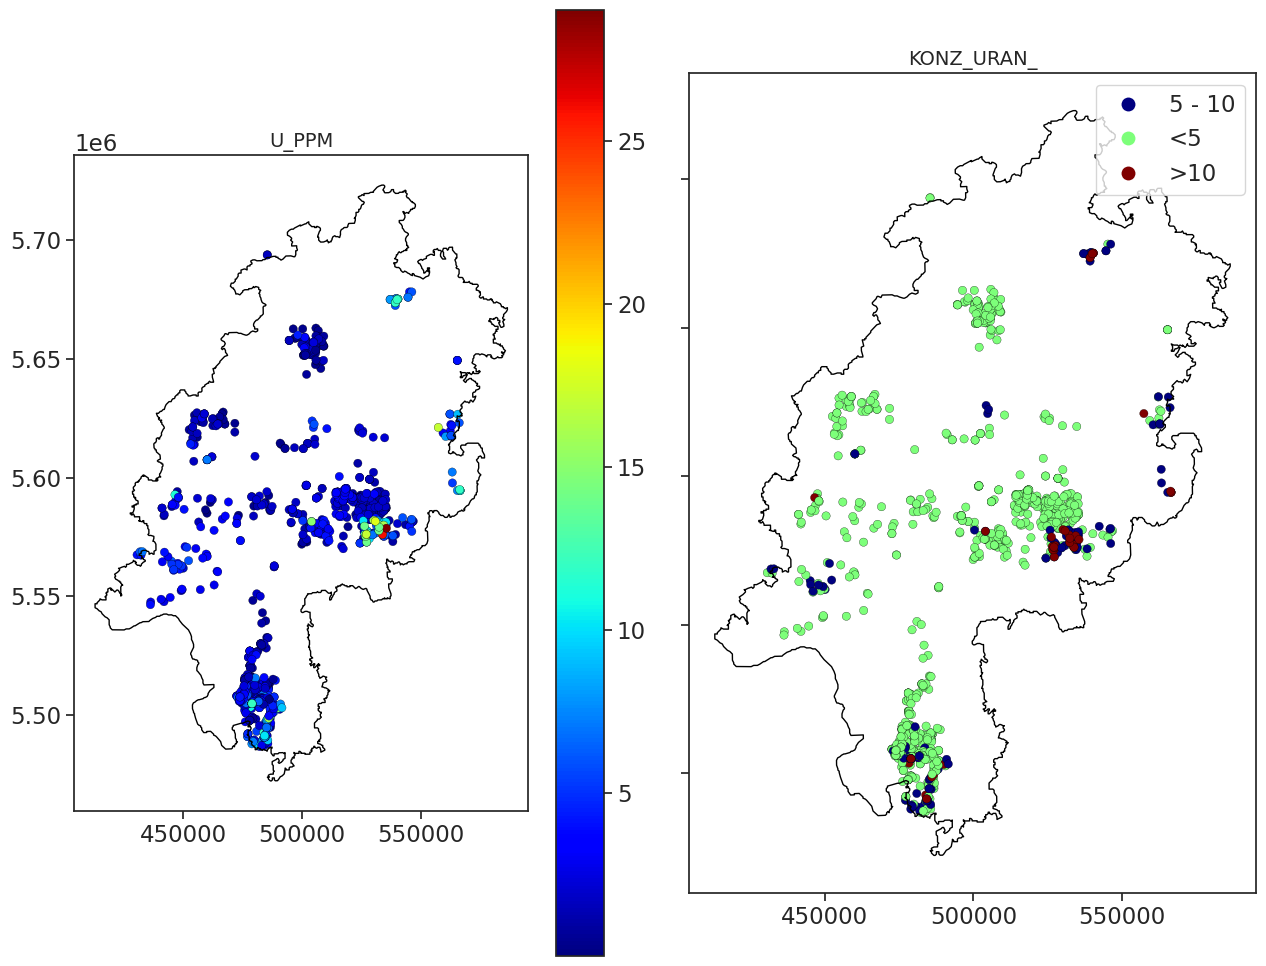



Histogram of Uranium




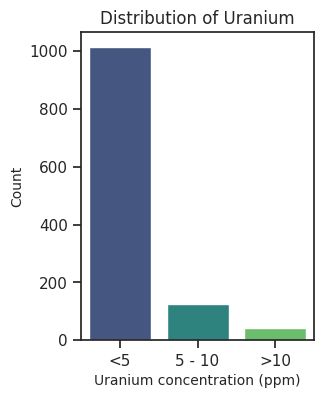

In [ ]:
# Plot of Uranium samples
ur_columns=['U_PPM', 'KONZ_URAN_']

fig, axes = plt.subplots(1,2, figsize=(13,10), sharex=True, sharey=True)
axes = axes.flatten()
for i, column in enumerate(ur_columns):
    ax = axes[i]
    Uranium.plot(column=column, cmap='jet', ax=ax, legend=True,
                 edgecolor='black', linewidth=0.2,)
    Hessen.plot(ax=ax, column='NAME_1', facecolor='none', edgecolor='black')
    ax.set_title(f"{column}", fontsize=14)
    #ax.axis('off')
    for j in range(len(ur_columns), 2):
        axes[j].axis('off')
plt.tight_layout()
plt.show()


print_seperator('Histogram of Uranium')

sns.set_theme(style='ticks', font_scale=1.0)
plt.figure(figsize=(3, 4))
sns.countplot(x=Uranium['KONZ_URAN_'], color='grey', palette='viridis')
plt.xlabel('Uranium concentration (ppm)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Uranium', fontsize=12)
plt.show()


In [ ]:
#plot_boxplot_by_category(Uranium, 'KONZ_URAN_', 'U_PPM', log_transform=False)



Boxplot of Uranium per geo unit




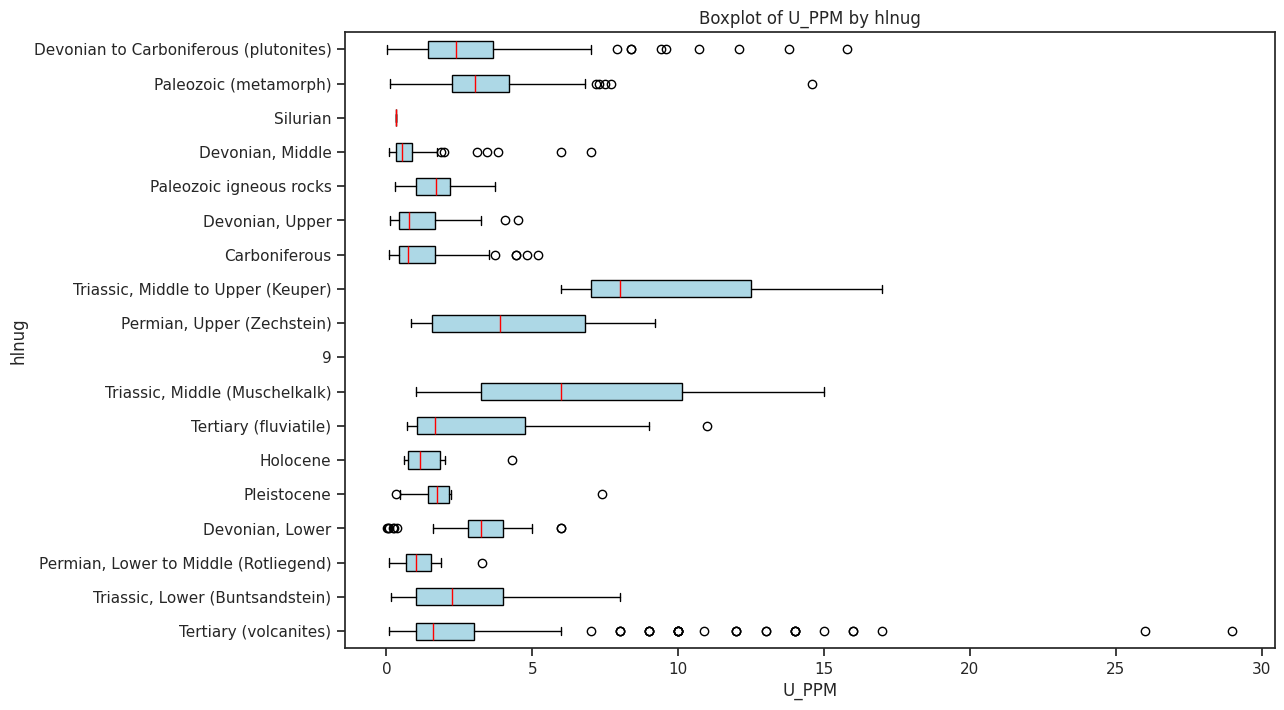



Histogram of Uranium per geo unit




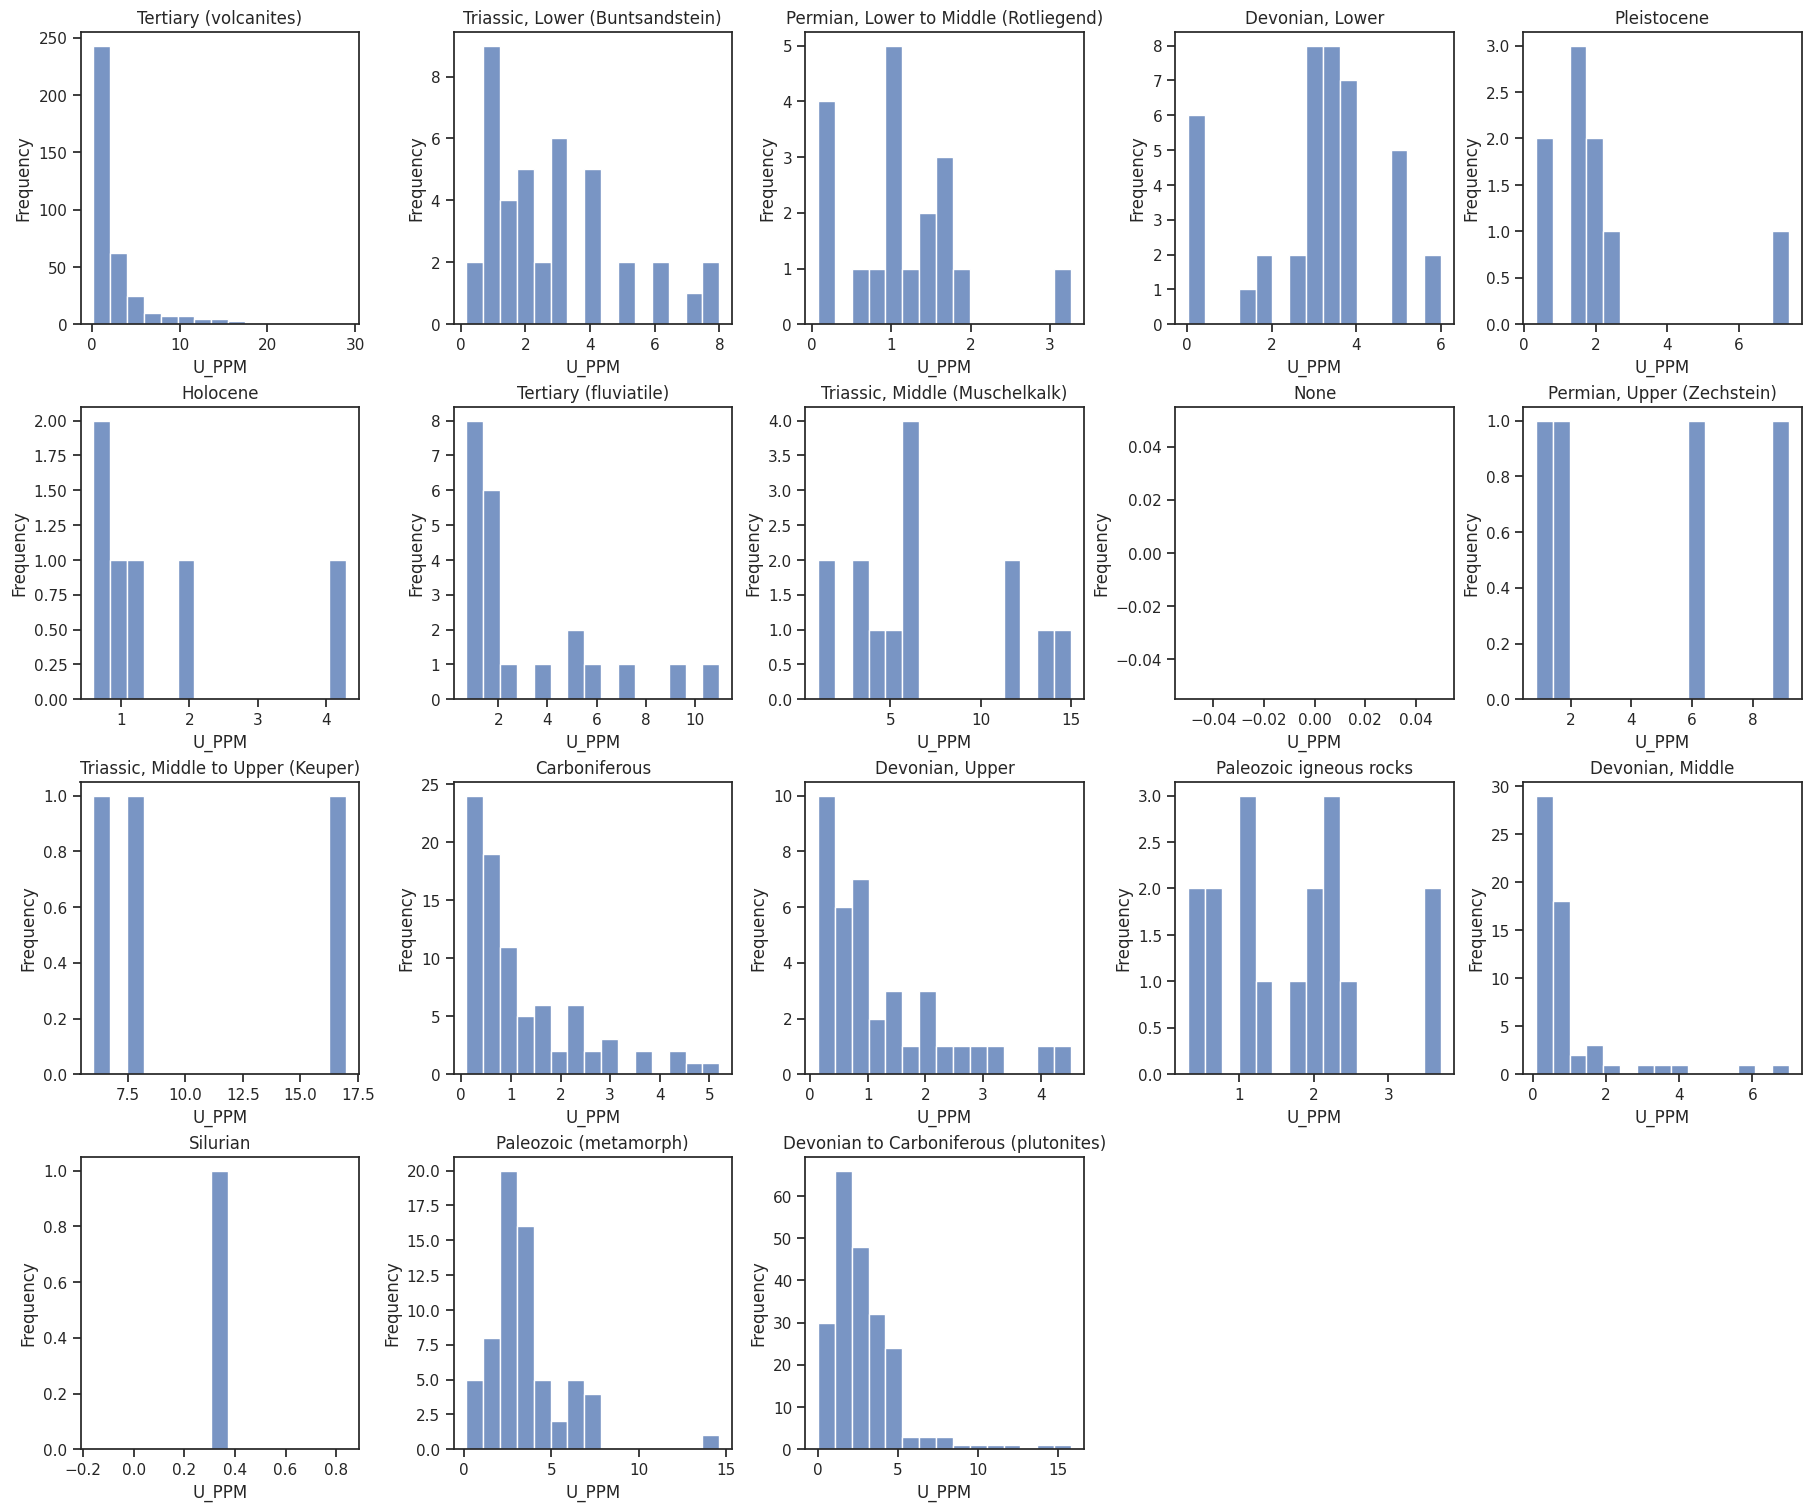

In [ ]:
processor_uranium = RenameUnit(Uranium, 'hlnug')
Uranium_geology_updated = processor_uranium.process_geology_columns()
print_seperator('Boxplot of Uranium per geo unit')

# Boxplot of Uranium per geo units
plot_boxplot_by_category(Uranium_geology_updated, 'hlnug', 'U_PPM', log_transform=False)
print_seperator('Histogram of Uranium per geo unit')

# Histogram of Uranium per geo unit
plot_histograms_by_category(Uranium_geology_updated, category_col='hlnug',
                            value_col='U_PPM', bins=15)

In [ ]:
# Aggregates table
print_seperator('Median Aggregate of Uranium ')

def Uranium_strata_median():
    data = pd.DataFrame(Uranium.groupby("hlnug").U_PPM
                    .agg(['min','max',
                          'mean','median',
                          'count','std']))
    data['Rank'] = data['median'].rank(ascending=False)
    Uranium_stat_median = data.sort_values('Rank')
    Uranium_stat_median = np.round(Uranium_stat_median, decimals=2)

    return Uranium_stat_median.reset_index()

print(Uranium_strata_median())

print_seperator('90%le Aggregate of Uranium ')

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def Uranium_strata_tile():
    data = pd.DataFrame(Uranium.groupby(["hlnug"]).U_PPM
                    .agg(['min','max',percentile(0.9),
                          'mean','median',
                          'count','std']))
    data['Rank'] = data['percentile_90'].rank(ascending=False)
    Uranium_stat_tile = data.sort_values('Rank')
    Uranium_stat_tile = Uranium_stat_tile.reset_index()
    return np.round(Uranium_stat_tile, decimals=2)

print(Uranium_strata_tile())



Median Aggregate of Uranium 


                                     hlnug   min    max   mean  median  count   std  Rank
0       Triassic, Middle to Upper (Keuper)  6.00  17.00  10.33    8.00      3  5.86   1.0
1           Triassic, Middle (Muschelkalk)  1.00  15.00   6.71    6.00     14  4.58   2.0
2               Permian, Upper (Zechstein)  0.85   9.20   4.46    3.90      4  3.87   3.0
3                          Devonian, Lower  0.03   6.00   3.11    3.26     41  1.57   4.0
4                    Paleozoic (metamorph)  0.12  14.60   3.58    3.05     66  2.25   5.0
5   Devonian to Carboniferous (plutonites)  0.02  15.80   2.83    2.40    215  2.23   6.0
6          Triassic, Lower (Buntsandstein)  0.17   8.00   2.84    2.25     40  2.04   7.0
7                              Pleistocene  0.33   7.40   2.17    1.73      9  2.08   8.0
8                  Paleozoic igneous rocks  0.31   3.71   1.69    1.71     17  1.03   9.0
9                    Tertiary (fluviatile)  0.69  11.00   3.07    1

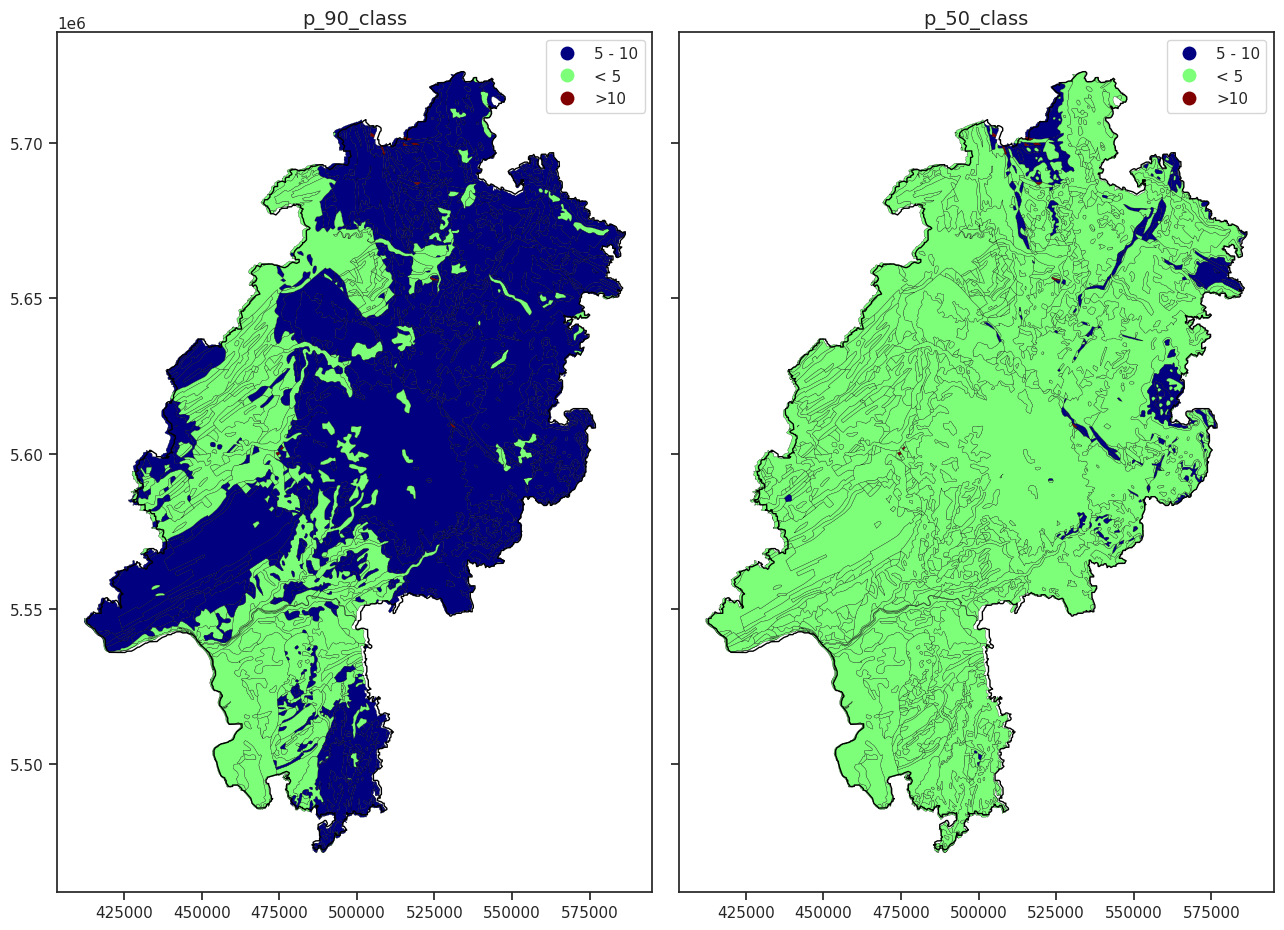

In [ ]:
# Add Uranium classes to geodataframe
Uranium_cl['p_90'] = Uranium_cl['hlnug'].map(Uranium_strata_tile().set_index('hlnug')['percentile_90'])
Uranium_cl['p_50'] = Uranium_cl['hlnug'].map(Uranium_strata_median().set_index('hlnug')['median'])

# get class categories
def urclass(x):
    if (x < 5):
        return '< 5'
    elif ((x >= 5) | (x <=10)):
        return '5 - 10'
    else:
        return '>10'

Uranium_cl['p_90_class'] = Uranium_cl['p_90'].apply(urclass)
Uranium_cl['p_50_class'] = Uranium_cl['p_50'].apply(urclass)

ur_columns=['p_90_class', 'p_50_class']

# plot median and 90%le classes
fig, axes = plt.subplots(1,2, figsize=(13,10), sharex=True, sharey=True)
axes = axes.flatten()
for i, column in enumerate(ur_columns):
    ax = axes[i]
    Uranium_cl.plot(column=column, cmap='jet', ax=ax, legend=True,
                 edgecolor='black', linewidth=0.2,)
    Hessen.plot(ax=ax, column='NAME_1', facecolor='none', edgecolor='black')
    ax.set_title(f"{column}", fontsize=14)
    #ax.axis('off')
    for j in range(len(ur_columns), 2):
        axes[j].axis('off')
plt.tight_layout()
plt.show()

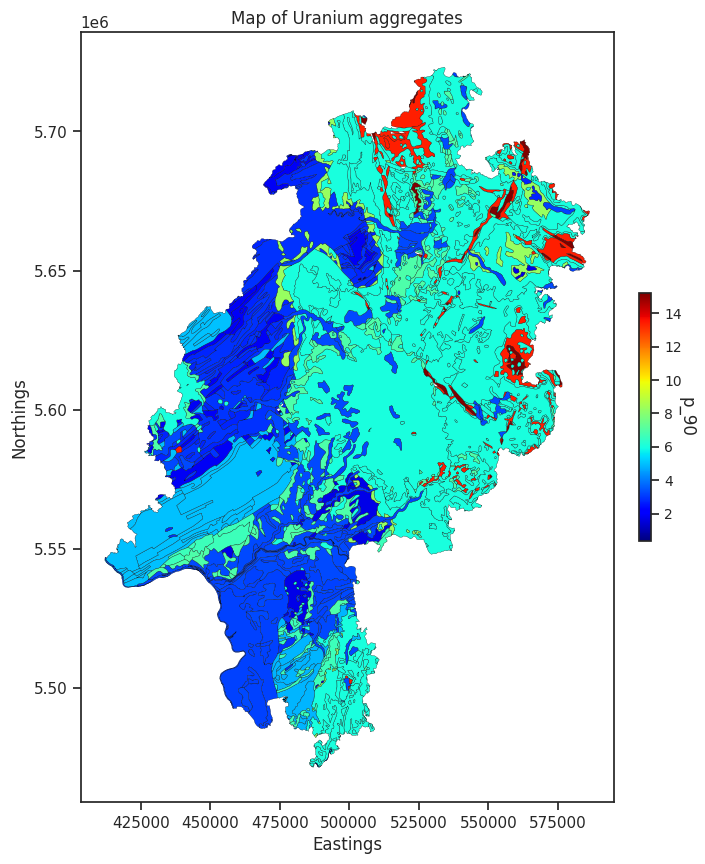

In [ ]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 10),)

# Plot the GeoDataFrame
Uranium_cl.plot(column='p_90',  cmap='jet', edgecolor='black', linewidth=0.2, ax=ax)

# Set color limits based on data
vmin = Uranium_cl['p_90'].min()
vmax = Uranium_cl['p_90'].max()

# Create a colorbar with shortened limits
sm = plt.cm.ScalarMappable(cmap='jet', norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('p_90', rotation=270, labelpad=10)
cbar.ax.tick_params(labelsize=10)  # Adjust color bar tick size if needed

# Set plot labels and title
plt.xlabel('Eastings', fontsize=12)
plt.ylabel('Northings', fontsize=12)
plt.title('Map of Uranium aggregates', fontsize=12)
#plt.axis('off')
plt.show()

## Saving to geopackage

In [ ]:
Geology_gpkg = os.path.join(base_dir, 'Geology.gpkg')
#Uranium_classes.to_file('Uranium_Radon_classification.shp')
Ur_Ra = GP.spatial_join_pol_pts(radon_df, Uranium_cl)

Uranium_cl.to_file(Geology_gpkg, layer='Uranium_map', driver="GPKG")
Ur_Ra.to_file(Geology_gpkg, layer='radon_and_uranium', driver="GPKG")